In [1]:
import pandas as pd
import numpy as np

In [2]:
def load_and_clean_data(filepath, drop_cols=None, start_date="1963-01-01"):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    df.dropna(inplace=True)
    return df.loc[start_date:].copy()

sp500 = load_and_clean_data("data/sp_daily.csv")
rf = load_and_clean_data("data/fama_daily.csv", drop_cols=['mktrf', 'smb', 'hml', 'umd'])

# Combine the two DataFrames on their index
df = sp500.join(rf, how='inner')


df

,spindx,sprtrn,rf
caldt,,,
1963-01-02,62.69,-0.006498,0.00011
1963-01-03,63.72,0.016430,0.00011
1963-01-04,64.13,0.006434,0.00011
1963-01-07,64.12,-0.000156,0.00011
1963-01-08,64.74,0.009669,0.00011
...,...,...,...
2024-12-24,6040.04,0.011043,0.00017
2024-12-26,6037.59,-0.000406,0.00017
2024-12-27,5970.84,-0.011056,0.00017


<Axes: xlabel='caldt'>

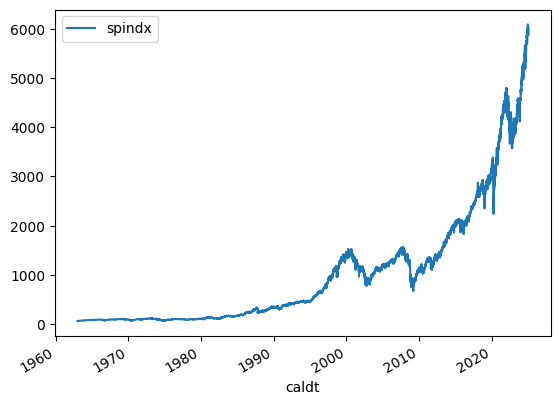

In [3]:
df.plot.line(y="spindx", use_index=True)

Compute log returns for simpler calculations in the future

In [4]:
# Convert simple S&P500 returns to log returns
df['sp_log_rtrn'] = np.log(1 + df['sprtrn'])

# Convert risk-free rate to log returns
df['rf_log_rtrn'] = np.log(1 + df['rf'])

# Calculate the excess log return
df['excess_log_rtrn'] = df['sp_log_rtrn'] - df['rf_log_rtrn']

# Optionally, drop the first row if you do not need the NaN value that results from the difference
df.dropna(inplace=True)

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn
caldt,,,,,,
1963-01-02,62.69,-0.006498,0.00011,-0.006519,0.00011,-0.006629
1963-01-03,63.72,0.016430,0.00011,0.016296,0.00011,0.016186
1963-01-04,64.13,0.006434,0.00011,0.006413,0.00011,0.006303
1963-01-07,64.12,-0.000156,0.00011,-0.000156,0.00011,-0.000266
1963-01-08,64.74,0.009669,0.00011,0.009623,0.00011,0.009513
...,...,...,...,...,...,...
2024-12-24,6040.04,0.011043,0.00017,0.010982,0.00017,0.010812
2024-12-26,6037.59,-0.000406,0.00017,-0.000406,0.00017,-0.000576
2024-12-27,5970.84,-0.011056,0.00017,-0.011118,0.00017,-0.011288


Compute Standard deviation and expected returns with a rolling window

In [5]:
horizon = 750 # 3 years of daily data

rolling_var = df["sp_log_rtrn"].rolling(horizon).var()
rolling_expected_rtrn = df["sp_log_rtrn"].rolling(horizon).mean()
rolling_expected_rf = df["rf_log_rtrn"].rolling(horizon).mean()

df['rolling_var'] = rolling_var
df['rolling_expected_rtrn'] = rolling_expected_rtrn
df['rolling_expected_rf'] = rolling_expected_rf  

Create a target variable by comparing if the S&P 500 of the risk-free rate will have a better performance during the next 3 months.

In [6]:
# Define the forward-looking window (e.g., 63 trading days for about 3 months)
window = 63

# Compute the forward cumulative log returns using a reversed rolling sum:
df['sp_cum_log_rtrn'] = df['sp_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)
df['rf_cum_log_rtrn'] = df['rf_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)

# Create the Target variable: 1 if the S&P 500 cumulative log return is higher than the risk-free rate, else 0
df['Target'] = (df['sp_cum_log_rtrn'] > df['rf_cum_log_rtrn']).astype(int)

# remove columns with missing values
df.dropna(inplace=True)


# Optional: inspect the resulting DataFrame
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,rf_cum_log_rtrn,Target
caldt,,,,,,,,,,,,
1965-12-22,92.29,0.003043,0.00015,0.003038,0.00015,0.002888,0.000019,0.000507,0.000137,-0.034837,0.010989,0
1965-12-23,92.19,-0.001084,0.00015,-0.001085,0.00015,-0.001235,0.000019,0.000514,0.000137,-0.031959,0.011009,0
1965-12-27,91.52,-0.007268,0.00015,-0.007295,0.00015,-0.007445,0.000019,0.000483,0.000137,-0.021868,0.011029,0
1965-12-28,91.53,0.000109,0.00015,0.000109,0.00015,-0.000041,0.000019,0.000474,0.000137,-0.021084,0.011049,0
1965-12-29,91.81,0.003059,0.00015,0.003054,0.00015,0.002904,0.000019,0.000479,0.000137,-0.028051,0.011069,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,5722.26,-0.001861,0.00020,-0.001863,0.00020,-0.002063,0.000123,0.000379,0.000135,0.054046,0.011399,1
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000123,0.000369,0.000135,0.049610,0.011369,1
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000123,0.000385,0.000135,0.039746,0.011339,1


Check if the training window contains both cases (0 and 1) as Target Variables

In [7]:
window = 750
invalid_window_found = False  # flag to track if any window is missing a class

# Slide the window one step at a time
for i in range(len(df) - window + 1):
    window_values = df['Target'].iloc[i:i+window].values
    
    # Check if this window does NOT contain both 0 and 1
    if not (0 in window_values and 1 in window_values):
        invalid_window_found = True
        break  # no need to test further if one invalid window is found

print("Invalid window found: ", invalid_window_found)


Invalid window found:  False


## Add Technical Indicators

Average Price (Moving Average)

In [8]:
new_predictors = []

ma_horizons = [4, 21, 55]

for horizon in ma_horizons:
    rolling_means = df["spindx"].rolling(horizon).mean()
    ratio_column = f"ma_ratio_{horizon}"
    df[ratio_column] = df["spindx"] / rolling_means  # Use the Series directly

    new_predictors += [ratio_column]



Volatility

In [9]:
# Compute the 10-day volatility (rolling standard deviation)
df['volatility_10'] = df['spindx'].rolling(window=10).std()

# Optionally, add this new predictor to your predictors list
new_predictors.append('volatility_10')


Moving average convergence divergence (MACD)

In [10]:
# set parameters
n = 42 # slow EMA
m = 21 # fast EMA
p = 14  # signal line

# Calculate EMAs
df[f'slow_EMA_{n}'] = df['spindx'].ewm(span=n, adjust=False).mean()
df[f'fast_EMA_{m}'] = df['spindx'].ewm(span=m, adjust=False).mean()
df[f'signal_EMA_{p}'] = df['spindx'].ewm(span=p, adjust=False).mean()

df[f'slow_EMA_ratio{n}'] = df["spindx"] / df[f'slow_EMA_{n}']
df[f'fast_EMA_ratio{m}'] = df["spindx"] / df[f'fast_EMA_{m}']
df[f'signal_EMA_ratio{p}'] = df["spindx"] / df[f'signal_EMA_{p}']

# Compute MACD and Signal line
df['MACD'] = df[f'fast_EMA_{m}'] - df[f'slow_EMA_{n}']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Strategy: 1 when MACD > Signal, else -1
df['MACD_Strategy'] = (df['MACD'] > df['Signal']).astype(int)

# # TEMA Strategy: 
# conditions = [
#     (df[f'fast_EMA_{m}'] > df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] > df[f'signal_EMA_{p}']),
#     (df[f'fast_EMA_{m}'] < df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] < df[f'signal_EMA_{p}'])
# ]
# choices = [1, -1]
# df['TEMA_Strategy'] = np.select(conditions, choices, default=0)



# Add new predictors to the list
new_predictors += [f'slow_EMA_ratio{n}', f'fast_EMA_ratio{m}', f'signal_EMA_ratio{p}', 'MACD']#, 'MACD_Strategy', 'TEMA_Strategy']

Plot MACD and TEMA

In [11]:
# import matplotlib.pyplot as plt

# # Slice the DataFrame for period of interest
# df_slice = df.loc['2008':'2010']

# # Compute the transitions for MACD_Strategy:
# macd_diff = df_slice['MACD_Strategy'].diff().fillna(0)
# buy_macd = df_slice[macd_diff == 1]    # Transition from 0 to 1 (buy)
# sell_macd = df_slice[macd_diff == -1]    # Transition from 1 to 0 (sell)

# # Compute the transitions for TEMA_Strategy:
# tema_diff = df_slice['TEMA_Strategy'].diff().fillna(0)
# buy_tema = df_slice[tema_diff == 1]    # Transition from hold/sell to buy (1)
# sell_tema = df_slice[tema_diff == -1]   # Transition from buy/hold to sell (-1)

# # Create the plot with the base price series and EMAs using dynamic naming
# plt.figure(figsize=(12, 6))
# plt.plot(df_slice.index, df_slice['spindx'], label='SP Index', color='blue')
# plt.plot(df_slice.index, df_slice[f'slow_EMA_{n}'], label=f'Slow EMA ({n})', linestyle='--', color='red')
# plt.plot(df_slice.index, df_slice[f'fast_EMA_{m}'], label=f'Fast EMA ({m})', linestyle='--', color='green')
# plt.plot(df_slice.index, df_slice[f'signal_EMA_{p}'], label=f'Signal EMA ({p})', linestyle='--', color='orange')

# # Overlay MACD transition signals on the SP Index:
# plt.scatter(buy_macd.index, buy_macd['spindx'], marker='^', color='green', s=100, label='MACD Buy')
# plt.scatter(sell_macd.index, sell_macd['spindx'], marker='v', color='red', s=100, label='MACD Sell')

# # Overlay TEMA transition signals on the SP Index:
# plt.scatter(buy_tema.index, buy_tema['spindx'], marker='o', facecolors='none', edgecolors='purple', s=100, label='TEMA Buy')
# plt.scatter(sell_tema.index, sell_tema['spindx'], marker='x', color='brown', s=100, label='TEMA Sell')

# plt.title(f"SP Index and EMAs with MACD/TEMA Signal Transitions ({df_slice.index.min().year}-{df_slice.index.max().year})\n(slow_EMA_{n}, fast_EMA_{m}, signal_EMA_{p})")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

Momentum

In [12]:
momentum_periods = [12, 25, 63]  

for period in momentum_periods:
    diff_column = f"momentum_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[diff_column] = df["spindx"] / (df["spindx"] - df["spindx"].shift(period))
    
    # Optionally add this to your predictors list.
    new_predictors.append(diff_column)

Rate of change (ROC):

In [13]:
for period in momentum_periods:
    roc_column = f"ROC_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[roc_column] = (df["spindx"] - df["spindx"].shift(period)) / df["spindx"].shift(period)
    
    # Optionally add this to your predictors list.
    new_predictors.append(roc_column)

Relative Strength Index (RSI)

In [14]:
rsi_periods = [25]

for period in rsi_periods:
    rsi_col = f"RSI_{period}"
    
    # 1. Calculate Up and Down from daily log returns
    #    - 'Up' is the positive portion of the return
    #    - 'Down' is the positive portion of the negative return
    #      (we negate it so it's a positive number when returns are negative)
    up = df['sp_log_rtrn'].clip(lower=0)
    down = -df['sp_log_rtrn'].clip(upper=0)
    
    # 2. Compute rolling means of Up and Down over 'period' days
    #    (using a simple moving average for illustration)
    roll_up = up.rolling(window=period).mean()
    roll_down = down.rolling(window=period).mean()
    
    # 3. Calculate the Relative Strength (RS) = average(Up) / average(Down)
    RS = roll_up / roll_down
    
    # 4. Compute the RSI using the standard formula
    #    RSI = 100 - [ 100 / (1 + RS) ]
    df[rsi_col] = 100 - (100 / (1 + RS))
    
    # 5. Append the new column name to your predictors list
    new_predictors.append(rsi_col)


Detrended Price Oscillator (DPO):

In [15]:
# Example array of periods for the DPO
dpo_periods = ma_horizons

for n in dpo_periods:
    # Calculate the shift for the SMA: (n//2) + 1
    shift_n = (n // 2) + 1
    
    # Compute the n-period Simple Moving Average
    sma_n = df['spindx'].rolling(window=n).mean()
    
    # Shift the SMA by shift_n periods
    sma_shifted = sma_n.shift(shift_n)
    
    # Compute DPO as the difference between today's price and the shifted SMA
    dpo_col = f"DPO_{n}"
    df[dpo_col] = df['spindx'] - sma_shifted
    
    # Optionally add the new DPO column to your list of predictors
    new_predictors.append(dpo_col)

Sharpe Ratio (SR):

In [16]:
rolling_window = 750  # 3 years of daily data

# Compute the rolling Sharpe ratio: 
df[f'sharpe_{rolling_window}'] = df['excess_log_rtrn'].rolling(window=rolling_window).mean() / \
                                 df['sp_log_rtrn'].rolling(window=rolling_window).std()

new_predictors.append(f'sharpe_{rolling_window}')

Min/Max value over time prediction prior to period:

In [17]:
lookback_periods = [63, 252, 750] # 3 months, 1 year, 3 years

for period in lookback_periods:
    # Compute the rolling maximum and shift by one to exclude today's price.
    rolling_max = df["spindx"].rolling(window=period).max().shift(1)
    max_ratio_column = f"max_ratio_{period}"
    df[max_ratio_column] = df["spindx"] / rolling_max
    
    # Compute the rolling minimum and shift by one.
    rolling_min = df["spindx"].rolling(window=period).min().shift(1)
    min_ratio_column = f"min_ratio_{period}"
    df[min_ratio_column] = df["spindx"] / rolling_min
    
    new_predictors.extend([max_ratio_column, min_ratio_column])


In [18]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,DPO_4,DPO_21,DPO_55,sharpe_750,max_ratio_63,min_ratio_63,max_ratio_252,min_ratio_252,max_ratio_750,min_ratio_750
caldt,,,,,,,,,,,,,,,,,,,,,
1965-12-22,92.29,0.003043,0.00015,0.003038,0.00015,0.002888,0.000019,0.000507,0.000137,-0.034837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-12-23,92.19,-0.001084,0.00015,-0.001085,0.00015,-0.001235,0.000019,0.000514,0.000137,-0.031959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-12-27,91.52,-0.007268,0.00015,-0.007295,0.00015,-0.007445,0.000019,0.000483,0.000137,-0.021868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-12-28,91.53,0.000109,0.00015,0.000109,0.00015,-0.000041,0.000019,0.000474,0.000137,-0.021084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-12-29,91.81,0.003059,0.00015,0.003054,0.00015,0.002904,0.000019,0.000479,0.000137,-0.028051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,5722.26,-0.001861,0.00020,-0.001863,0.00020,-0.002063,0.000123,0.000379,0.000135,0.054046,...,55.0025,181.043333,279.286727,0.021958,0.998139,1.103335,0.998139,1.389785,0.998139,1.599724
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000123,0.000369,0.000135,0.049610,...,57.1150,194.165714,297.173091,0.021058,1.002170,1.107791,1.002170,1.395398,1.002170,1.606184
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000123,0.000385,0.000135,0.039746,...,21.2475,179.283333,283.195455,0.022476,0.998747,1.106403,0.998747,1.393649,0.998747,1.604172


## Add Macro Vairables:

In [19]:
import glob
import pandas as pd
from pathlib import Path

# — your master DataFrame of trading‑day data
# df = pd.read_csv(..., index_col=0, parse_dates=True)
# df.index is sorted, business days only

# 1) make a full calendar index from first to last trading day
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# 2) which tags are truly “daily” vs “monthly-on-1st”
daily_tags   = ['DGS10', 'DCOILWTICO']
# if there are monthly CSVs you still want, they just get the else‑branch

file_paths = glob.glob("data/macro_variables/**/*.csv", recursive=True)
macro_dfs  = []

for path in file_paths:
    tag = Path(path).stem
    
    # read it in with the first column as a datetime index
    temp = pd.read_csv(path, index_col=0, parse_dates=True)
    temp.columns = [f"{tag}_{col}" for col in temp.columns]
    
    # reindex to the full daily calendar and ffill
    #  - for daily_tags this fills weekends/holidays
    #  - for monthly data (1st‑of‑month) this holds that value until next month
    temp = temp.reindex(full_idx).ffill()
    
    # now drop the artificial days, keep only your trading‑day slice
    temp = temp.reindex(df.index)
    
    macro_dfs.append(temp)

# 3) combine all the macro series side by side, drop any rows with missing
df_macro = pd.concat(macro_dfs, axis=1).dropna()




In [20]:
df_macro

,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,DCOILWTICO_DCOILWTICO,BAA_AAA_BAA_AAA
caldt,,,,,,
1986-01-02,9.04,7.07,55.6453,109.900,25.56,1.39
1986-01-03,9.05,7.07,55.6453,109.900,26.00,1.39
1986-01-06,9.07,7.07,55.6453,109.900,26.53,1.39
1986-01-07,8.94,7.07,55.6453,109.900,25.85,1.39
1986-01-08,9.13,7.07,55.6453,109.900,25.87,1.39
...,...,...,...,...,...,...
2024-09-25,3.79,4.72,102.5954,314.851,70.42,0.74
2024-09-26,3.79,4.72,102.5954,314.851,68.28,0.74
2024-09-27,3.75,4.72,102.5954,314.851,68.72,0.74


In [21]:
# 4) join back onto your trading‑day df
df = df.join(df_macro, how='inner')

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,max_ratio_252,min_ratio_252,max_ratio_750,min_ratio_750,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,DCOILWTICO_DCOILWTICO,BAA_AAA_BAA_AAA
caldt,,,,,,,,,,,,,,,,,,,,,
1986-01-02,209.59,-0.007999,0.00025,-0.008031,0.00025,-0.008281,0.000057,0.000485,0.000333,0.103609,...,0.988539,1.280486,0.988539,1.497392,9.04,7.07,55.6453,109.900,25.56,1.39
1986-01-03,210.88,0.006155,0.00025,0.006136,0.00025,0.005886,0.000057,0.000484,0.000333,0.081079,...,0.994623,1.288368,0.994623,1.506609,9.05,7.07,55.6453,109.900,26.00,1.39
1986-01-06,210.65,-0.001091,0.00025,-0.001092,0.00025,-0.001342,0.000057,0.000482,0.000333,0.081909,...,0.993538,1.286962,0.993538,1.504965,9.07,7.07,55.6453,109.900,26.53,1.39
1986-01-07,213.80,0.014954,0.00025,0.014843,0.00025,0.014593,0.000057,0.000505,0.000333,0.088228,...,1.008395,1.303738,1.008395,1.527470,8.94,7.07,55.6453,109.900,25.85,1.39
1986-01-08,207.97,-0.027268,0.00025,-0.027647,0.00025,-0.027897,0.000058,0.000478,0.000333,0.116859,...,0.972732,1.268187,0.972732,1.485818,9.13,7.07,55.6453,109.900,25.87,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,5722.26,-0.001861,0.00020,-0.001863,0.00020,-0.002063,0.000123,0.000379,0.000135,0.054046,...,0.998139,1.389785,0.998139,1.599724,3.79,4.72,102.5954,314.851,70.42,0.74
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000123,0.000369,0.000135,0.049610,...,1.002170,1.395398,1.002170,1.606184,3.79,4.72,102.5954,314.851,68.28,0.74
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000123,0.000385,0.000135,0.039746,...,0.998747,1.393649,0.998747,1.604172,3.75,4.72,102.5954,314.851,68.72,0.74


Change macro values from absolute to relative values by dividing the values with their moving average

In [22]:

horizon = 750 # 3 years of daily data
absolute_cols = ['INDPRO_INDPRO', 'CPIAUCSL_CPIAUCSL', 'TB3MS_TB3MS', 'DGS10_DGS10', 'DCOILWTICO_DCOILWTICO']
macro_predictors = ['BAA_AAA_BAA_AAA']

for col in absolute_cols:
    rolling_means = df[f"{col}"].rolling(horizon).mean()
    ratio_column = f"{col}_ratio"
    df[ratio_column] = df[f"{col}"] / rolling_means  # Use the Series directly
    
    macro_predictors += [ratio_column]  

new_predictors = [p for p in new_predictors if p not in macro_predictors]

# Drop the original absolute columns
df.drop(columns=absolute_cols, inplace=True)
# Add the new macro predictors to your list
new_predictors += macro_predictors


Overview of all columns in the dataframe

In [23]:
df.dropna(inplace=True)

# print df column names
print(df.columns.tolist())

['spindx', 'sprtrn', 'rf', 'sp_log_rtrn', 'rf_log_rtrn', 'excess_log_rtrn', 'rolling_var', 'rolling_expected_rtrn', 'rolling_expected_rf', 'sp_cum_log_rtrn', 'rf_cum_log_rtrn', 'Target', 'ma_ratio_4', 'ma_ratio_21', 'ma_ratio_55', 'volatility_10', 'slow_EMA_42', 'fast_EMA_21', 'signal_EMA_14', 'slow_EMA_ratio42', 'fast_EMA_ratio21', 'signal_EMA_ratio14', 'MACD', 'Signal', 'MACD_Strategy', 'momentum_rel_diff_12', 'momentum_rel_diff_25', 'momentum_rel_diff_63', 'ROC_rel_diff_12', 'ROC_rel_diff_25', 'ROC_rel_diff_63', 'RSI_25', 'DPO_4', 'DPO_21', 'DPO_55', 'sharpe_750', 'max_ratio_63', 'min_ratio_63', 'max_ratio_252', 'min_ratio_252', 'max_ratio_750', 'min_ratio_750', 'BAA_AAA_BAA_AAA', 'INDPRO_INDPRO_ratio', 'CPIAUCSL_CPIAUCSL_ratio', 'TB3MS_TB3MS_ratio', 'DGS10_DGS10_ratio', 'DCOILWTICO_DCOILWTICO_ratio']


Overview of all predictors that will be used to train the AI model

In [24]:
new_predictors

['ma_ratio_4',
 'ma_ratio_21',
 'ma_ratio_55',
 'volatility_10',
 'slow_EMA_ratio42',
 'fast_EMA_ratio21',
 'signal_EMA_ratio14',
 'MACD',
 'momentum_rel_diff_12',
 'momentum_rel_diff_25',
 'momentum_rel_diff_63',
 'ROC_rel_diff_12',
 'ROC_rel_diff_25',
 'ROC_rel_diff_63',
 'RSI_25',
 'DPO_4',
 'DPO_21',
 'DPO_55',
 'sharpe_750',
 'max_ratio_63',
 'min_ratio_63',
 'max_ratio_252',
 'min_ratio_252',
 'max_ratio_750',
 'min_ratio_750',
 'BAA_AAA_BAA_AAA',
 'INDPRO_INDPRO_ratio',
 'CPIAUCSL_CPIAUCSL_ratio',
 'TB3MS_TB3MS_ratio',
 'DGS10_DGS10_ratio',
 'DCOILWTICO_DCOILWTICO_ratio']

## Initialize the model

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# n_estimators: number of individual trees we want to train. The higher the number, the more accurate the model will be (up to a limit).
# min_samples_split: protects from overfitting (random forests tend to overfit by building deep trees). The higher the number, the less overfitting but also less accuracy.
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, random_state=42)

In [26]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data
    preds = model.predict_proba(test[predictors])[:,1]  # Get the probability that the stock goes up

    # Calculate the precision score #
    pred_prob = pd.Series(preds.copy(), index=test.index, name="Pred_probability")
    
    #set a high threshold for the prediction to be true
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Risk Aversion Coefficient Calculation #
    risk_aversion_vals = (test['rolling_expected_rtrn'] * 100 - test['rolling_expected_rf'] * 100) / ((pred_prob) * 100 * df['rolling_var'])
    risk_aversion = pd.Series(risk_aversion_vals, index=test.index, name="risk_aversion_coefficient")

    # 6. Combine everything into a single DataFrame
    combined = pd.concat([test["Target"], preds, pred_prob, risk_aversion], axis=1)

    
    # Return predictions as a Series with the same index as the test data
    return combined

Always use 3 years (750 days) for training, predict for the upcoming 3 months (63 days) and then retrain the model every 3 months again to have an up-to date model

In [27]:
def backtest(data, model, predictors, start=750, step=63):
    """
    Backtest the model on the given data.
    Parameters:
        data (DataFrame): The data to backtest on.
        model: The model to use for predictions.
        predictors (list): The list of predictor columns.
        start (int): The starting index for the backtest. Every trading year has around 250 trading days.
        2500 is around 10 years. Train first model on 10 years of data.
        step (int): The step size for the backtest. Train a model every 250 days (1 trading year).
    """
    # list of dataframes where each dataframe is a prediction for a single year
    all_predictions = []
    
    # for i in range(start, data.shape[0], step):
    #     # Split the data into training and testing sets -> training set is all the years prior to the current year, gets bigger with each iteration
    #     train = data.iloc[:i].copy() # all the years prior to the current year
    #     test = data.iloc[i:i + step].copy() # the current year
        
    
    for i in range(0, data.shape[0] - start - step + 1, step):
        # The training set always consists of exactly 'window' entries.
        train = data.iloc[i : i + start].copy()
        # The testing set consists of the next 'step' entries.
        test = data.iloc[i + start : i + start + step].copy()
        
        # Make predictions using the predict function
        preds = predict(train, test, predictors, model)
        
        # Append predictions to the list
        all_predictions.append(preds)
    
    # Concatenate all predictions into a single DataFrame
    results = pd.concat(all_predictions)
    return results

Clean data and remove very low or high values

In [28]:
# Replace infinities with NaNs first
df[new_predictors] = df[new_predictors].replace([np.inf, -np.inf], np.nan)

# Forward fill, then backward fill as a fallback:
df[new_predictors] = df[new_predictors].fillna(method='ffill')


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_80070/2907752904.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[new_predictors] = df[new_predictors].fillna(method='ffill')


In [54]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,max_ratio_252,min_ratio_252,max_ratio_750,min_ratio_750,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio,DCOILWTICO_DCOILWTICO_ratio
caldt,,,,,,,,,,,,,,,,,,,,,
1988-12-16,276.29,0.007328,0.00030,0.007301,0.00030,0.007001,0.000220,0.000358,0.000229,0.048158,...,0.974018,1.138730,0.820412,1.357757,1.08,1.065600,1.060733,1.319467,1.105309,1.004454
1988-12-19,278.91,0.009483,0.00030,0.009438,0.00030,0.009138,0.000220,0.000381,0.000229,0.043571,...,0.983255,1.149528,0.828191,1.370632,1.08,1.065445,1.060599,1.319179,1.102879,0.971116
1988-12-20,277.47,-0.005163,0.00030,-0.005176,0.00030,-0.005476,0.000220,0.000366,0.000229,0.045860,...,0.978178,1.143593,0.823915,1.363556,1.08,1.065290,1.060465,1.318892,1.094437,1.057927
1988-12-21,277.38,-0.000324,0.00030,-0.000324,0.00030,-0.000624,0.000220,0.000367,0.000229,0.040972,...,0.977861,1.143222,0.823648,1.363114,1.08,1.065135,1.060331,1.318604,1.093231,1.034157
1988-12-22,276.87,-0.001839,0.00030,-0.001841,0.00030,-0.002141,0.000220,0.000345,0.000230,0.048300,...,0.976063,1.141120,0.822134,1.360607,1.08,1.064981,1.060197,1.318317,1.093208,1.040252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,5722.26,-0.001861,0.00020,-0.001863,0.00020,-0.002063,0.000123,0.000379,0.000135,0.054046,...,0.998139,1.389785,0.998139,1.599724,0.74,1.000026,1.047878,1.292579,1.090192,0.841864
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000123,0.000369,0.000135,0.049610,...,1.002170,1.395398,1.002170,1.606184,0.74,0.999997,1.047700,1.290379,1.089227,0.816381
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000123,0.000385,0.000135,0.039746,...,0.998747,1.393649,0.998747,1.604172,0.74,0.999968,1.047522,1.288186,1.076798,0.821759


## Make predictions and backtest the model

Backtest the given data using the initiated Random Forest Classifier model and the previously computet predictors

In [29]:
# predictions = backtest(df, model, new_predictors)
predictions = backtest(df, model, new_predictors)

Define function to report and evaluate the model

In [30]:
from sklearn.metrics import precision_score

def report_predictions(predictions):
    
    print("========== MODEL REPORTING ==========\n")
    
    # 1) Distribution of predicted classes
    print("1) Predictions value counts:")
    print(predictions["Predictions"].value_counts(), "\n")
    
    # 2) Precision of the positive class (1)
    prec = precision_score(predictions["Target"], predictions["Predictions"])
    print(f"2) Precision score (Target vs. Predictions): {prec:.4f}\n")
    
    # 3) Proportion of each true class in the sample
    print("3) Target class proportions:")
    print((predictions["Target"].value_counts() / len(predictions)).rename("proportion"), "\n")
    
    # 4) Median predicted probability (from your monthly model)
    med_prob = predictions["Pred_probability"].median()
    print(f"4) Median prediction probability: {med_prob:.4f}\n")
    
    # 5) Median inferred risk aversion coefficient
    med_risk = predictions["risk_aversion_coefficient"].median()
    print(f"5) Median risk aversion coefficient: {med_risk:.4f}\n")
    
    print("======================================")

# Example usage:
# report_model(predictions, monthly_df)


Select the relevant timeframe for our study to match the available data for 5 year predictions

In [31]:
# label-based slice from 1995‑02‑01 through 2020‑01‑31 (inclusive)
predictions = predictions.loc['1995-01-01' : '2019-12-31'].copy()


In [32]:
report_predictions(predictions)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
1.0    4246
0.0    2048
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.7756

3) Target class proportions:
Target
1    0.662854
0    0.337146
Name: proportion, dtype: float64 

4) Median prediction probability: 0.6382

5) Median risk aversion coefficient: 5.2946



In [33]:
predictions

,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1995-01-03,1,1.0,0.840815,-0.575859
1995-01-04,1,1.0,0.743081,-0.162784
1995-01-05,1,1.0,0.753252,-0.282498
1995-01-06,1,1.0,0.739039,0.056872
1995-01-09,1,1.0,0.710677,0.558403
...,...,...,...,...
2019-12-24,0,0.0,0.441258,14.620362
2019-12-26,0,0.0,0.479764,13.314816
2019-12-27,0,1.0,0.523526,11.986077


Just take the last prediction value each month and assign it to the end of month date

In [34]:
# Ensure the index is in datetime format
predictions.index = pd.to_datetime(predictions.index)

# Resample by month to get the last available row of each month,
# but assign the row to the proper month-end date.
# The resample with 'M' uses the month-end as the bin label.
monthly_eom_df = predictions.resample('M', label='right', closed='right').last()

# At this point, monthly_df.index is already set to the month's last day.
monthly_eom_df.index.name = 'caldt'

# Round the values in "Target" and "Predictions" to either 0 or 1 based on threshold 0.5
monthly_eom_df['Target'] = monthly_eom_df['Target'].apply(lambda x: 1 if x >= 0.5 else 0)
monthly_eom_df['Predictions'] = monthly_eom_df['Predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Display the resulting monthly DataFrame with one row per month
monthly_eom_df


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_80070/156827199.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_eom_df = predictions.resample('M', label='right', closed='right').last()


,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1995-01-31,1,0,0.349434,2.154246
1995-02-28,1,0,0.185824,18.229759
1995-03-31,1,1,0.738172,5.877381
1995-04-30,1,1,0.738741,5.792863
1995-05-31,1,1,0.671394,9.803859
...,...,...,...,...
2019-08-31,1,1,0.875894,5.710570
2019-09-30,1,1,0.927005,6.132409
2019-10-31,1,1,0.689929,9.083135


In [35]:
report_predictions(monthly_eom_df)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
1    207
0     93
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.7729

3) Target class proportions:
Target
1    0.673333
0    0.326667
Name: proportion, dtype: float64 

4) Median prediction probability: 0.6560

5) Median risk aversion coefficient: 5.3051



In [36]:
# Find the index of the minimum value
min_idx = monthly_eom_df["risk_aversion_coefficient"].idxmax()

# Print the entire row at that index
print(monthly_eom_df.loc[min_idx])

Target                         0.000000
Predictions                    0.000000
Pred_probability               0.045425
risk_aversion_coefficient    189.674385
Name: 2018-09-30 00:00:00, dtype: float64


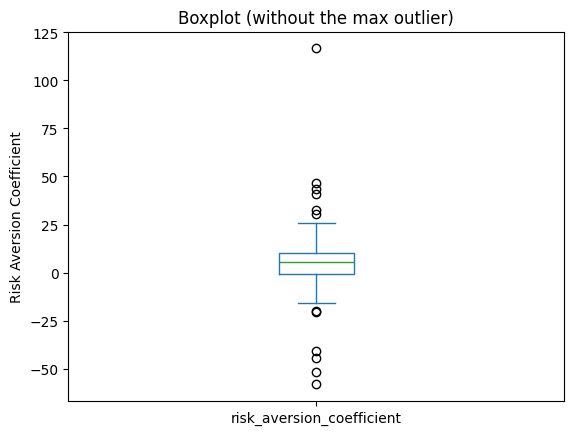

In [37]:
import matplotlib.pyplot as plt

# remove the extreme outlier
mean_m_df_dropped = monthly_eom_df.drop(index=min_idx)

plt.figure()
mean_m_df_dropped["risk_aversion_coefficient"].plot.box()
plt.ylabel("Risk Aversion Coefficient")
plt.title("Boxplot (without the max outlier)")
plt.show()

## Biased AI

In [57]:
import pandas as pd

window = 750
cutoff_date = '1995-01-01'

# 1. Ensure sorted index (MANDATORY for rolling windows)
df = df.sort_index()

# 2. Build 0/1 mask for the ENTIRE dataset
zero_mask_all = (df['Target'] == 0).astype(int)

# 3. Full dataset rolling sums (for mean/median)
rolling_all = zero_mask_all.rolling(window=window, min_periods=window).sum()

# 4. Pre‑cutoff dataset and its rolling sums (for max/mean/median)
df_pre95 = df.loc[df.index < cutoff_date]
zero_mask_pre = (df_pre95['Target'] == 0).astype(int)  # Explicitly align with pre‑cutoff
rolling_pre = zero_mask_pre.rolling(window=window, min_periods=window).sum()

# 5. Pre‑cutoff: Max zeros and window
max_zeros_pre = int(rolling_pre.max())
end_pre = rolling_pre.idxmax()
end_pos_pre = df_pre95.index.get_indexer([end_pre])[0]
start_pos_pre = end_pos_pre - window + 1
start_pre = df_pre95.index[start_pos_pre]

# 6. Mean/median for both periods
mean_pre = rolling_pre.mean()
median_pre = rolling_pre.median()
mean_all = rolling_all.mean()
median_all = rolling_all.median()

# 7. REPORT (matches original structure)
print("===== Zero‑Count Analysis =====")
print(f"Window size: {window} rows\n")

print(f"1) Before {cutoff_date}:")
print(f"   • Max zeros in any window: {max_zeros_pre}")
print(f"     Period: {start_pre.date()} to {end_pre.date()}")
print(f"   • Mean zeros per window:   {mean_pre:.2f}")
print(f"   • Median zeros per window: {median_pre:.2f}\n")

print("2) Entire dataset:")
print(f"   • Mean zeros per window:   {mean_all:.2f}")
print(f"   • Median zeros per window: {median_all:.2f}")

# 8. (Optional) Extract best window
best_slice_pre95 = df_pre95.loc[start_pre:end_pre]

===== Zero‑Count Analysis =====
Window size: 750 rows

1) Before 1995-01-01:
   • Max zeros in any window: 372
     Period: 1989-07-26 to 1992-07-13
   • Mean zeros per window:   296.35
   • Median zeros per window: 293.00

2) Entire dataset:
   • Mean zeros per window:   256.47
   • Median zeros per window: 238.00


Train the model using biased data and make predictions on the dataframe entries relevant for the study

In [39]:
biased_train = df.loc['1989-07-25':'1992-07-22'].copy()
biased_test = df.iloc[-7489:-1195].copy()

preds_biased = predict(biased_train, biased_test, new_predictors, model)


In [40]:
report_predictions(preds_biased)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
0.0    4331
1.0    1963
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.5976

3) Target class proportions:
Target
1    0.662854
0    0.337146
Name: proportion, dtype: float64 

4) Median prediction probability: 0.4339

5) Median risk aversion coefficient: 9.6169



Only take end of month biased results

In [41]:
# Ensure the index is in datetime format
preds_biased.index = pd.to_datetime(preds_biased.index)

# Resample by month to get the last available row of each month,
# but assign the row to the proper month-end date.
# The resample with 'M' uses the month-end as the bin label.
bias_monthly_eom_df = preds_biased.resample('M', label='right', closed='right').last()

# At this point, monthly_df.index is already set to the month's last day.
bias_monthly_eom_df.index.name = 'caldt'

# # Round the values in "Target" and "Predictions" to either 0 or 1 based on threshold 0.5
# bias_monthly_eom_df['Target'] = bias_monthly_eom_df['Target'].apply(lambda x: 1 if x >= 0.5 else 0)
# bias_monthly_eom_df['Predictions'] = bias_monthly_eom_df['Predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Display the resulting monthly DataFrame with one row per month
bias_monthly_eom_df


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_80070/2921149676.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bias_monthly_eom_df = preds_biased.resample('M', label='right', closed='right').last()


,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1995-01-31,1,0.0,0.471907,1.595161
1995-02-28,1,0.0,0.386559,8.763289
1995-03-31,1,0.0,0.366379,11.841604
1995-04-30,1,0.0,0.391986,10.917311
1995-05-31,1,0.0,0.392259,16.780394
...,...,...,...,...
2019-08-31,1,0.0,0.409013,12.229078
2019-09-30,1,0.0,0.396963,14.320682
2019-10-31,1,0.0,0.355875,17.609344


In [42]:
report_predictions(bias_monthly_eom_df)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
0.0    205
1.0     95
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.6000

3) Target class proportions:
Target
1    0.673333
0    0.326667
Name: proportion, dtype: float64 

4) Median prediction probability: 0.4457

5) Median risk aversion coefficient: 9.5189



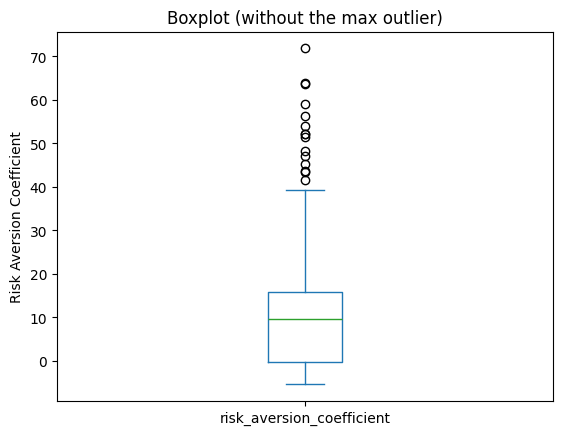

In [43]:
import matplotlib.pyplot as plt

plt.figure()
bias_monthly_eom_df["risk_aversion_coefficient"].plot.box()
plt.ylabel("Risk Aversion Coefficient")
plt.title("Boxplot (without the max outlier)")
plt.show()

## Export both prediction dataframes as CSV

Unbiased decisions for 3 months into the future

In [44]:
monthly_eom_df

,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1995-01-31,1,0,0.349434,2.154246
1995-02-28,1,0,0.185824,18.229759
1995-03-31,1,1,0.738172,5.877381
1995-04-30,1,1,0.738741,5.792863
1995-05-31,1,1,0.671394,9.803859
...,...,...,...,...
2019-08-31,1,1,0.875894,5.710570
2019-09-30,1,1,0.927005,6.132409
2019-10-31,1,1,0.689929,9.083135


Biased decisions for 3 months into the future

In [45]:
bias_monthly_eom_df

,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1995-01-31,1,0.0,0.471907,1.595161
1995-02-28,1,0.0,0.386559,8.763289
1995-03-31,1,0.0,0.366379,11.841604
1995-04-30,1,0.0,0.391986,10.917311
1995-05-31,1,0.0,0.392259,16.780394
...,...,...,...,...
2019-08-31,1,0.0,0.409013,12.229078
2019-09-30,1,0.0,0.396963,14.320682
2019-10-31,1,0.0,0.355875,17.609344


In [46]:
diff_idx = monthly_eom_df.index.symmetric_difference(
    bias_monthly_eom_df.index
)
print("Dates not in both frames:")
print(diff_idx)

Dates not in both frames:
DatetimeIndex([], dtype='datetime64[ns]', name='caldt', freq='ME')


In [47]:
import uuid

def transform_for_db(
    daily_trading_df: pd.DataFrame,
    monthly_pred_df: pd.DataFrame,
    scenario_id: str
) -> pd.DataFrame:
 
    # 1) Build a full calendar of days from first to last trading date
    cal_idx = pd.date_range(
        start=daily_trading_df.index.min(),
        end  =daily_trading_df.index.max(),
        freq ='D',
        name =daily_trading_df.index.name
    )

    # 2) Reindex & forward‑fill so every calendar day has the last known value
    daily_full = daily_trading_df.reindex(cal_idx).ffill()

    # 3) Keep only real trading days plus every month‑end
    month_ends = pd.date_range(
        start=daily_trading_df.index.min(),
        end  =daily_trading_df.index.max(),
        freq ='M'
    )
    allowed_idx = daily_trading_df.index.union(month_ends)
    daily_plus_me = daily_full.loc[allowed_idx]

    # 4) Join the two cum‑return series onto the monthly predictions
    merged = monthly_pred_df.join(
        daily_plus_me[['sp_cum_log_rtrn','rf_cum_log_rtrn']],
        how='left'
    ).copy()

    # 5) Compute fund allocations: first *100, cast to int for fund_b, then subtract from 100 for fund_a
    merged['fund_b'] = (merged['Pred_probability'] * 100).astype(int)
    merged['fund_a'] = 100 - merged['fund_b']

    # 6) Rename return columns and drop originals + unneeded cols
    merged = (
        merged
        .rename(columns={
            'sp_cum_log_rtrn':'return_b',
            'rf_cum_log_rtrn':'return_a'
        })
        .drop(columns=[
            'Target','Predictions',
            'Pred_probability','risk_aversion_coefficient'
        ])
    )

    # 7) Insert a trial_number 1…N as the first column
    merged.insert(0, 'trial_number', range(1, len(merged) + 1))

    # 8) Tag every row with the provided scenario_id
    merged['scenario_id'] = scenario_id

    # 9) Add UUID columns for recommendation and fund return
    merged['recommendation_id'] = [uuid.uuid4() for _ in range(len(merged))]
    merged['fund_return_id'] = [uuid.uuid4() for _ in range(len(merged))]

    return merged


In [48]:
# insert the scenario_id from scenario_config database table
unbiased_long = transform_for_db(df, monthly_eom_df, '2e1e164a-699c-4c00-acff-61a98e23ddec')
unbiased_long

/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_80070/108693531.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = pd.date_range(


,trial_number,return_b,return_a,fund_b,fund_a,scenario_id,recommendation_id,fund_return_id
caldt,,,,,,,,
1995-01-31,1,0.090270,0.013439,34,66,2e1e164a-699c-4c00-acff-61a98e23ddec,60d2697f-bc70-4ca0-823e-a4b5307d7bb2,1068fcdd-594c-4397-bdc0-be2a844ac0a0
1995-02-28,2,0.071625,0.014008,18,82,2e1e164a-699c-4c00-acff-61a98e23ddec,b930375a-dcda-4c38-a410-b1890127fbdb,0af8bcd4-5637-4c13-96b1-375b0fc6509c
1995-03-31,3,0.084303,0.014268,73,27,2e1e164a-699c-4c00-acff-61a98e23ddec,486a7455-61ea-4b19-924c-9a3d6ca2b8fe,196387da-a2c4-4840-85c6-434c9fdb6a80
1995-04-30,4,0.089554,0.014268,73,27,2e1e164a-699c-4c00-acff-61a98e23ddec,8c5a2c95-ae6d-46c6-acea-fc06f5082524,ae2399ce-8793-4473-80ed-201837d29e61
1995-05-31,5,0.048667,0.013419,67,33,2e1e164a-699c-4c00-acff-61a98e23ddec,65f124f0-0261-499c-9461-cc719c6564f0,ad61aaec-eedd-41b3-b53a-febaa34258e1
...,...,...,...,...,...,...,...,...
2019-08-31,296,0.070745,0.004610,87,13,2e1e164a-699c-4c00-acff-61a98e23ddec,666fa2ff-9177-47fd-bd0f-700f325fb8af,4dd79829-28d1-452f-afc7-ad262fa8e51a
2019-09-30,297,0.078955,0.004210,92,8,2e1e164a-699c-4c00-acff-61a98e23ddec,265bb6be-6159-41b6-b6f6-4b525a96bff9,3063a955-5aa8-47c5-97bc-440dbd6d3c7a
2019-10-31,298,0.067267,0.003990,68,32,2e1e164a-699c-4c00-acff-61a98e23ddec,bf342f6b-6c2a-4aca-b4d2-48a9b76ae2a2,7aa4e19c-1dbd-4d5c-bf1d-96be43934b81


In [49]:
# compute mins and maxes
print(unbiased_long['return_a'].min())
print(unbiased_long['return_a'].max())
print(unbiased_long['return_b'].min())
print(unbiased_long['return_b'].max())



0.0
0.015698040726572497
-0.3586181634955369
0.22344333306813124


In [50]:
biased_long = transform_for_db(df, bias_monthly_eom_df, 'b8426ff5-c6f2-4f25-a259-764e993ffa29')
biased_long

/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_80070/108693531.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = pd.date_range(


,trial_number,return_b,return_a,fund_b,fund_a,scenario_id,recommendation_id,fund_return_id
caldt,,,,,,,,
1995-01-31,1,0.090270,0.013439,47,53,b8426ff5-c6f2-4f25-a259-764e993ffa29,5395d745-9a0e-417f-908b-e4fb2154e5a7,e3e73781-4b60-41f9-b5b5-8fc195fec0c2
1995-02-28,2,0.071625,0.014008,38,62,b8426ff5-c6f2-4f25-a259-764e993ffa29,455df641-aa76-4277-b777-a599a09cb860,71c4041e-acd5-4ea9-8075-85c45f6f22f1
1995-03-31,3,0.084303,0.014268,36,64,b8426ff5-c6f2-4f25-a259-764e993ffa29,4cef97ec-4a52-4e4f-ad5f-f4c7434ec462,b713c597-be82-4dd1-8291-4b45799cb6ae
1995-04-30,4,0.089554,0.014268,39,61,b8426ff5-c6f2-4f25-a259-764e993ffa29,7d84cab7-8e7b-4b37-ab2b-c58b91482108,a85a052d-66e8-47b2-ac9b-a74ea0b5626b
1995-05-31,5,0.048667,0.013419,39,61,b8426ff5-c6f2-4f25-a259-764e993ffa29,baa83a80-ceb4-4569-a3da-1e3998e90626,14ae6ddf-a299-4d15-a4db-d24dcea5a880
...,...,...,...,...,...,...,...,...
2019-08-31,296,0.070745,0.004610,40,60,b8426ff5-c6f2-4f25-a259-764e993ffa29,53342696-f51a-494f-804e-d28d5528bcb9,d74d0d67-d3a0-4715-bc01-a9bc8bb4acb4
2019-09-30,297,0.078955,0.004210,39,61,b8426ff5-c6f2-4f25-a259-764e993ffa29,6423dd5f-914c-4c02-82f3-681441c4cfec,2fb478c3-905a-4991-afd6-67a6b3000848
2019-10-31,298,0.067267,0.003990,35,65,b8426ff5-c6f2-4f25-a259-764e993ffa29,c3cfcef9-2540-4d15-bb0e-f02fd9c9046c,34f85df3-1a57-4ea6-bcf8-96119f4086df


In [51]:
# compute mins and maxes
print(biased_long['return_a'].min())
print(biased_long['return_a'].max())
print(biased_long['return_b'].min())
print(biased_long['return_b'].max())



0.0
0.015698040726572497
-0.3586181634955369
0.22344333306813124


In [52]:
import os
import pandas as pd

def export_as_csv(
    export_df: pd.DataFrame,
    base_name: str
) -> None:
    """
    Exports two CSV files from `export_df` in data/output/:
      1) {base_name}_ai_recommendations.csv  → columns: scenario_id, trial_number, fund_a, fund_b
      2) {base_name}_fund_returns.csv        → columns: scenario_id, trial_number, return_a, return_b

    If the files already exist, they will be overwritten.
    
    Parameters
    ----------
    export_df : pd.DataFrame
        Must contain columns:
          ['scenario_id', 'trial_number', 'fund_a', 'fund_b', 'return_a', 'return_b']
    base_name : str
        Base filename (no extension), e.g. "biased_long"
    """
    # Build full paths
    ai_csv_path      = os.path.join("data", "output", "ai_recommendations", f"{base_name}_ai_recommendations.csv")
    returns_csv_path = os.path.join("data", "output", "fund_returns", f"{base_name}_fund_returns.csv")

    # Ensure output directory exists
    os.makedirs(os.path.dirname(ai_csv_path), exist_ok=True)
    os.makedirs(os.path.dirname(returns_csv_path), exist_ok=True)


    # 1) Export AI recommendations (overwrites by default)
    ai_df = export_df[['scenario_id', 'recommendation_id',  'trial_number', 'fund_a', 'fund_b']]
    ai_df.to_csv(ai_csv_path, index=False)

    # 2) Export fund returns (overwrites by default)
    returns_df = export_df[['scenario_id', 'fund_return_id', 'trial_number', 'return_a', 'return_b']]
    returns_df.to_csv(returns_csv_path, index=False)

    print(f"Exported:\n - {ai_csv_path}\n - {returns_csv_path}")


In [53]:
export_as_csv(unbiased_long, 'unbiased_long')
export_as_csv(biased_long, 'biased_long')


Exported:
 - data/output/ai_recommendations/unbiased_long_ai_recommendations.csv
 - data/output/fund_returns/unbiased_long_fund_returns.csv
Exported:
 - data/output/ai_recommendations/biased_long_ai_recommendations.csv
 - data/output/fund_returns/biased_long_fund_returns.csv
